In [111]:
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from matplotlib import cm
import numpy as np
from wordcloud import WordCloud
import re, string
import sys
import seaborn as sns
sns.set()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from itertools import chain
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from PIL import Image


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaseymathues/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kaseymathues/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaseymathues/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kaseymathues/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


LifeStyles Healthcare would like to understand their products and customers better by analyzing product reviews from their branded pages on Amazon.com.  The team has decided to conduct a sentiment analysis, so that the organization can gain insights outside of star ratings. The sentiment analysis can also help the team predict a star rating based on the reviews.  By analyzing customer reviews the team also hopes to address customer issues and identify additional key words to use in their marketing campaigns. 

# LOAD THE DATA IN

In [82]:
#read in csv file
df = pd.read_csv('Resources/US_Reviews.csv')

In [83]:
df.head(2)

,Retailer ID,Retailer Name,Retailer SKU,UPC,Model Number,Title,Brand,Category,Subcategory,Week ID,Week Ending,Review Date,Review ID,Review Stars,Is Verified,Has Response,Review Text,Review Title,Reviews Url,Reviewer
0,1,Amazon.com,B0735Q681B,7.544650e+11,70907205419,SKYN Elite – 36 Count – Ultra-Thin Lubricated...,SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,R3A94R1G39RSYD,5,yes,no,Pretty good rubbers. Great for pounding and ...,Good Rubbers,https://www.amazon.com/gp/customer-reviews/R3A...,Fat Dabs
1,1,Amazon.com,B00WX0RJVS,8.858930e+11,2076438,SKYN Elite Condoms 10 Count (Pack of 1),SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,R2MBHRRN9LP4VS,5,yes,no,They are good out of the whole box i did hav...,They are good,https://www.amazon.com/gp/customer-reviews/R2M...,Roberto coronado medina


In [84]:
#rename headings
df.rename(columns={'Retailer ID': 'retailer_id', 'Retailer Name': 'retailer_name', 'Retailer SKU': 'retailer_sku', 'Week ID': 'week_id', 'Week Ending':'week_ending', 'Review Date':'review_date','Review ID':'review_id','Review Stars':'review_stars','Is Verified':'is_verified','Has Response':'has_response', 'Review Text':'review_text', 'Review Title':'review_title', 'Reviews Url':'reviews_url'}, inplace=True)
df.head(2)

,retailer_id,retailer_name,retailer_sku,UPC,Model Number,Title,Brand,Category,Subcategory,week_id,week_ending,review_date,review_id,review_stars,is_verified,has_response,review_text,review_title,reviews_url,Reviewer
0,1,Amazon.com,B0735Q681B,7.544650e+11,70907205419,SKYN Elite – 36 Count – Ultra-Thin Lubricated...,SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,R3A94R1G39RSYD,5,yes,no,Pretty good rubbers. Great for pounding and ...,Good Rubbers,https://www.amazon.com/gp/customer-reviews/R3A...,Fat Dabs
1,1,Amazon.com,B00WX0RJVS,8.858930e+11,2076438,SKYN Elite Condoms 10 Count (Pack of 1),SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,R2MBHRRN9LP4VS,5,yes,no,They are good out of the whole box i did hav...,They are good,https://www.amazon.com/gp/customer-reviews/R2M...,Roberto coronado medina


In [85]:
#combine the review text and the review title
df['combined_text'] = df['review_text'] + ' ' + df['review_title']

#change is verfied to 1 or 0 to prep for machine learning models
df['is_verified'] = df['is_verified'].map({'yes': 1, 'no': 0})
df.head(2)

,retailer_id,retailer_name,retailer_sku,UPC,Model Number,Title,Brand,Category,Subcategory,week_id,...,review_date,review_id,review_stars,is_verified,has_response,review_text,review_title,reviews_url,Reviewer,combined_text
0,1,Amazon.com,B0735Q681B,7.544650e+11,70907205419,SKYN Elite – 36 Count – Ultra-Thin Lubricated...,SKYN,Sexual Wellness,Condoms,202245,...,11/12/2022,R3A94R1G39RSYD,5,1,no,Pretty good rubbers. Great for pounding and ...,Good Rubbers,https://www.amazon.com/gp/customer-reviews/R3A...,Fat Dabs,Pretty good rubbers. Great for pounding and ...
1,1,Amazon.com,B00WX0RJVS,8.858930e+11,2076438,SKYN Elite Condoms 10 Count (Pack of 1),SKYN,Sexual Wellness,Condoms,202245,...,11/12/2022,R2MBHRRN9LP4VS,5,1,no,They are good out of the whole box i did hav...,They are good,https://www.amazon.com/gp/customer-reviews/R2M...,Roberto coronado medina,They are good out of the whole box i did hav...


# CLEAN DATASET

In [86]:
#check for missing values
df.isnull().sum()

retailer_id        0
retailer_name      0
retailer_sku       0
UPC              258
Model Number     161
Title              0
Brand              0
Category           0
Subcategory        0
week_id            0
week_ending        0
review_date        0
review_id          0
review_stars       0
is_verified        0
has_response       0
review_text        5
review_title       0
reviews_url        0
Reviewer           0
combined_text      5
dtype: int64

In [87]:
#UPC & Model Number are not relevent to the analysis, so we can drop those columns
df.drop(['UPC', 'Model Number'], axis=1, inplace=True)

In [88]:
#There are 5 rows with missing reviews, so they should be dropped from the dataset
df.dropna(inplace = True)

In [89]:
#confirm there are no null values
for column in df.columns:
    print(f"Column {column} has {df[column].isnull().sum()} null values")

Column retailer_id has 0 null values
Column retailer_name has 0 null values
Column retailer_sku has 0 null values
Column Title has 0 null values
Column Brand has 0 null values
Column Category has 0 null values
Column Subcategory has 0 null values
Column week_id has 0 null values
Column week_ending has 0 null values
Column review_date has 0 null values
Column review_id has 0 null values
Column review_stars has 0 null values
Column is_verified has 0 null values
Column has_response has 0 null values
Column review_text has 0 null values
Column review_title has 0 null values
Column reviews_url has 0 null values
Column Reviewer has 0 null values
Column combined_text has 0 null values


In [90]:
#check for duplicates
print(f"Duplicate entries: {df.duplicated().sum()}")

Duplicate entries: 0


In [91]:
#check unique ratings
df['review_stars'].value_counts()

5    758
1    204
4    105
3     92
2     70
Name: review_stars, dtype: int64

In [224]:
#create a target column based on review stars in preparation for machine learning models
df['target']=[0  if x<=3 else 1 for x in df['review_stars']]
df.head(2)

,retailer_id,retailer_name,retailer_sku,Title,Brand,Category,Subcategory,week_id,week_ending,review_date,...,is_verified,has_response,review_text,review_title,reviews_url,Reviewer,combined_text,target,review_breakout,review_length
0,1,Amazon.com,B0735Q681B,SKYN Elite – 36 Count – Ultra-Thin Lubricated...,SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,...,1,no,Pretty good rubbers. Great for pounding and ...,Good Rubbers,https://www.amazon.com/gp/customer-reviews/R3A...,Fat Dabs,Pretty good rubbers. Great for pounding and ...,1,"[pretti, good, rubber, pound, kind, posit, fee...",11
1,1,Amazon.com,B00WX0RJVS,SKYN Elite Condoms 10 Count (Pack of 1),SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,...,1,no,They are good out of the whole box i did hav...,They are good,https://www.amazon.com/gp/customer-reviews/R2M...,Roberto coronado medina,They are good out of the whole box i did hav...,1,"[good, whole, two, rip, good]",5


In [309]:
#begin removing unnecessary words, so that we can focus on the important words in the dataset
stopword_list = stopwords.words('english')
stopword_list += list(string.punctuation)

#added additional words to the stopword list that would not add value to the sentiment analysis
stopword_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'"," '",
'said',"'s", "also",'one',":(",'com', '!', '-', '–', '?', '_',"/",'condom','skyn', 'wife','well','box','great','use',
'woman','like',"n't",'u','el','ye','yet', 'use','kid', 'brand','m√≠','esposa','la','encanta', 'y','los','volvere',
'comprar','box', 'get', 'feel', 'use', 'would', 'product','buy','condoms']
stopword_set = set(stopword_list)

# tokenization to make everything lowercase
def process_review(review):
    tokens = nltk.word_tokenize(review)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopword_list]
    return stopwords_removed

# Stemming & Lemmatatization will help us map multiple words to a common root word

# create a function stemming() and loop through each word in a review
def stemming(review):
    stemmed_review=[]
    for w in review:
        stemmed_review.append(ps.stem(w))
    return stemmed_review

# create a function  and loop through each word in  a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word=lemmatizer.lemmatize(word,pos='v') 
        lemma_list.append(lemma_word)
    return lemma_list

# Combine functions above and obtain cleaned text data for machine learning models 
def data_preprocessing(review):
    #tokenization, stop words removal, punctuation marks removel
    processed_review=list(map(process_review,review))
    # stemming
    stemming_reviews=list(map(stemming,processed_review))
    # lemmatization
    lemma_reviews=list(map(lemmatization,stemming_reviews))
    return lemma_reviews

cleaned_text_data=data_preprocessing(df['combined_text'])

In [310]:
df.head(2)

,retailer_id,retailer_name,retailer_sku,Title,Brand,Category,Subcategory,week_id,week_ending,review_date,...,is_verified,has_response,review_text,review_title,reviews_url,Reviewer,combined_text,target,review_breakout,review_length
0,1,Amazon.com,B0735Q681B,SKYN Elite – 36 Count – Ultra-Thin Lubricated...,SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,...,1,no,Pretty good rubbers. Great for pounding and ...,Good Rubbers,https://www.amazon.com/gp/customer-reviews/R3A...,Fat Dabs,Pretty good rubbers. Great for pounding and ...,1,"[pretti, good, rubber, pound, kind, posit, fee...",11
1,1,Amazon.com,B00WX0RJVS,SKYN Elite Condoms 10 Count (Pack of 1),SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,...,1,no,They are good out of the whole box i did hav...,They are good,https://www.amazon.com/gp/customer-reviews/R2M...,Roberto coronado medina,They are good out of the whole box i did hav...,1,"[good, whole, two, rip, good]",5


In [311]:
cleaned_text_data=data_preprocessing(df['combined_text'])

In [312]:
# add 2 new columns for machine learning model.  
#Review breakout has all stop words removed and 
#the review length is another data point to use in the machine learning model
df['review_breakout']=cleaned_text_data
df['review_length']=[len(x) for x in df['review_breakout']]

In [313]:
df.head(2)

,retailer_id,retailer_name,retailer_sku,Title,Brand,Category,Subcategory,week_id,week_ending,review_date,...,is_verified,has_response,review_text,review_title,reviews_url,Reviewer,combined_text,target,review_breakout,review_length
0,1,Amazon.com,B0735Q681B,SKYN Elite – 36 Count – Ultra-Thin Lubricated...,SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,...,1,no,Pretty good rubbers. Great for pounding and ...,Good Rubbers,https://www.amazon.com/gp/customer-reviews/R3A...,Fat Dabs,Pretty good rubbers. Great for pounding and ...,1,"[pretti, good, rubber, pound, kind, posit, fee...",11
1,1,Amazon.com,B00WX0RJVS,SKYN Elite Condoms 10 Count (Pack of 1),SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,...,1,no,They are good out of the whole box i did hav...,They are good,https://www.amazon.com/gp/customer-reviews/R2M...,Roberto coronado medina,They are good out of the whole box i did hav...,1,"[good, whole, two, rip, good]",5


In [314]:
#extract clean data for machine learning analysis
df.to_csv('Resources/machine_learning.csv', index=False)

# ANALYSIS

Create Word Clouds to identify the most commonly used words in positive & negative reviews

In [315]:
#isolate positive reviews for a positive word cloud
positive_reviews = df[df.target == 1]


,retailer_id,retailer_name,retailer_sku,Title,Brand,Category,Subcategory,week_id,week_ending,review_date,...,is_verified,has_response,review_text,review_title,reviews_url,Reviewer,combined_text,target,review_breakout,review_length
0,1,Amazon.com,B0735Q681B,SKYN Elite – 36 Count – Ultra-Thin Lubricated...,SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,...,1,no,Pretty good rubbers. Great for pounding and ...,Good Rubbers,https://www.amazon.com/gp/customer-reviews/R3A...,Fat Dabs,Pretty good rubbers. Great for pounding and ...,1,"[pretti, good, rubber, pound, kind, posit, fee...",11
1,1,Amazon.com,B00WX0RJVS,SKYN Elite Condoms 10 Count (Pack of 1),SKYN,Sexual Wellness,Condoms,202245,11/12/2022,11/12/2022,...,1,no,They are good out of the whole box i did hav...,They are good,https://www.amazon.com/gp/customer-reviews/R2M...,Roberto coronado medina,They are good out of the whole box i did hav...,1,"[good, whole, two, rip, good]",5


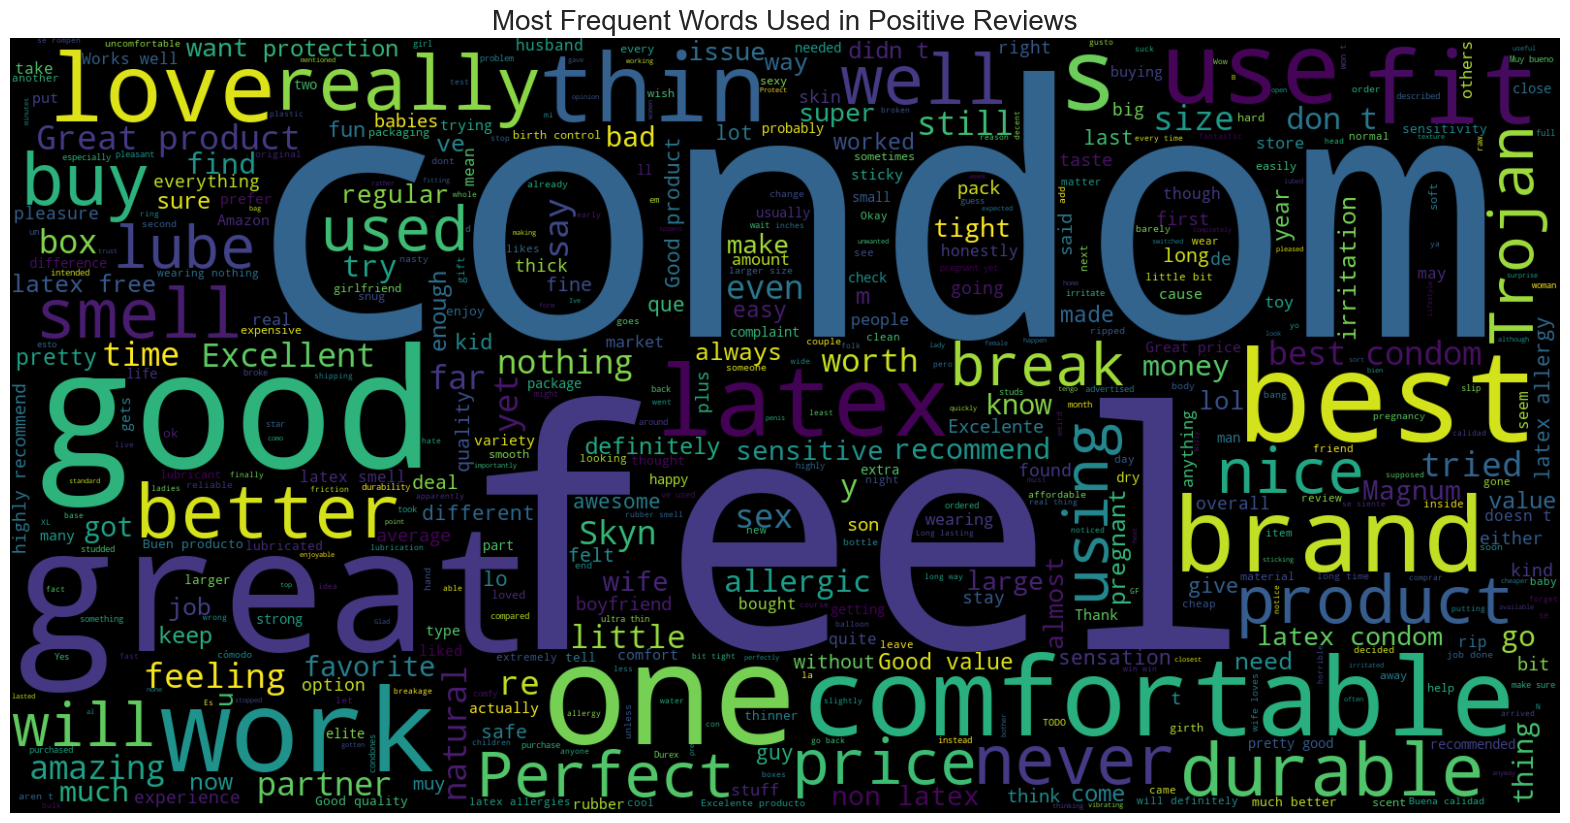

In [316]:
#positive word cloud
text = ' '.join([word for word in positive_reviews['combined_text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words Used in Positive Reviews', fontsize=20)
plt.show()

In [317]:
#isolate negative reviews for a negative word cloud
negative_reviews = df[df.target == 0]

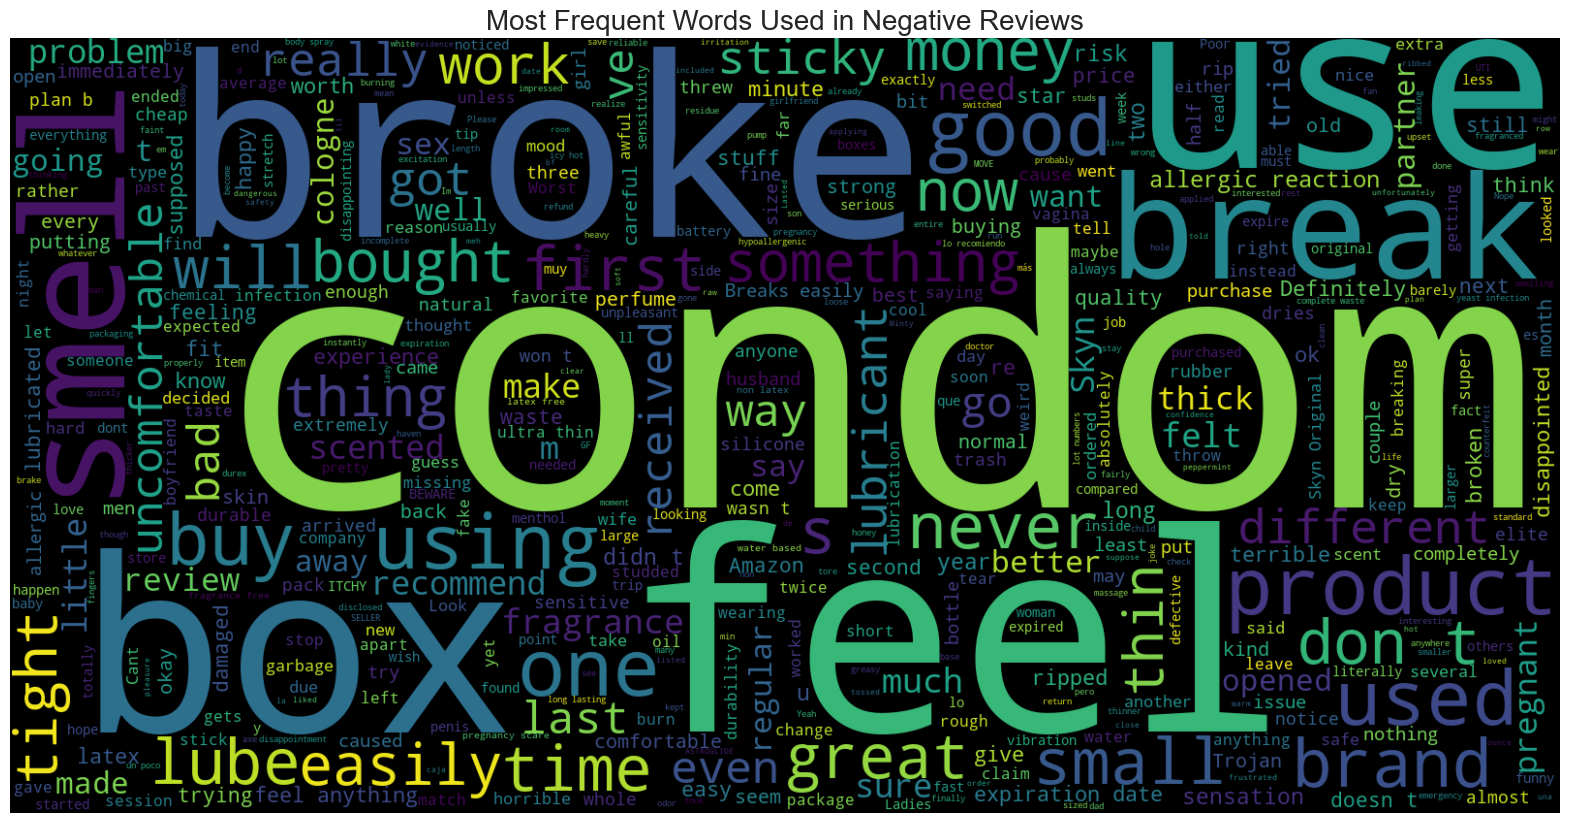

In [318]:
# negative word cloud
text = ' '.join([word for word in negative_reviews['combined_text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words Used in Negative Reviews', fontsize=20)
plt.show()

# For positive reviews, customers used words such as good, great, best, comfortable etc.
# For negative reviews, customers used words such as broke, break, smell, tight, small etc.

--------------------------------------------------------------------------------------------------------

Identify Top and Bottom rated products

In [319]:
#Top Rated Products
pd.DataFrame(df.groupby(['retailer_sku','Title'])['review_stars'].mean()).sort_values(by='review_stars',ascending=False).iloc[:5]

,,review_stars
retailer_sku,Title,
B004TTM2SG,"LifeStyles Pleasure Collection 12+1 Condoms Strawberry, Multi, 13 Count",5.000000
B07S6N1BJL,SKYN Elite 50Count,4.750000
B096W6RP89,"SKYN Selection Non-Latex Lubricated Condoms Variety Pack, 12 Count",4.600000
B09TQ6Q6Q9,SKYN Elite Extra Lubricated Condoms 36 Count,4.600000
B004TTXA7I,SKYN Original Condoms 24 Count (Pack of 1),4.485714


In [320]:
#Bottom Rated Products
pd.DataFrame(df.groupby(['retailer_sku','Title'])['review_stars'].mean()).sort_values(by='review_stars',ascending=True).iloc[:5]

,,review_stars
retailer_sku,Title,
B08PZCBZMS,Lifestyles Ultra Sensitive Platinum Large Latex Condom,1.000000
B07RZ12N7F,SKYN Thrill Massager,1.000000
B079JTGC5V,SKYN Elite – 22 Count – Ultra-Thin Lubricated Latex-Free Condoms,1.500000
B07TXTHP9L,SKYN Endurance Delay Spray – 0.17 fl. oz 42 sprays – Delay Spray for Men with Lidocaine for Long-Lasting Intimacy​,2.000000
B000VB95VS,Lifestyles 6903 Lifestyles Vibrating Ring 3-Count Package,3.052632


# By identifying the top rated products, Marketing can drive brand awareness by promoting the top ranked skus.  The marketing team also knows which skus they should focus on improving by identifying the least ranked products.  The marketing team can review the bottom ranked sku reviews in detail to understand the negative experience customers are having and then actioning against it.

---------------------------------------------------------------------------------

The majority of LifeStyles Healthcare reviews are positive

Text(0.5, 1.0, 'Good vs Bad Reviews')

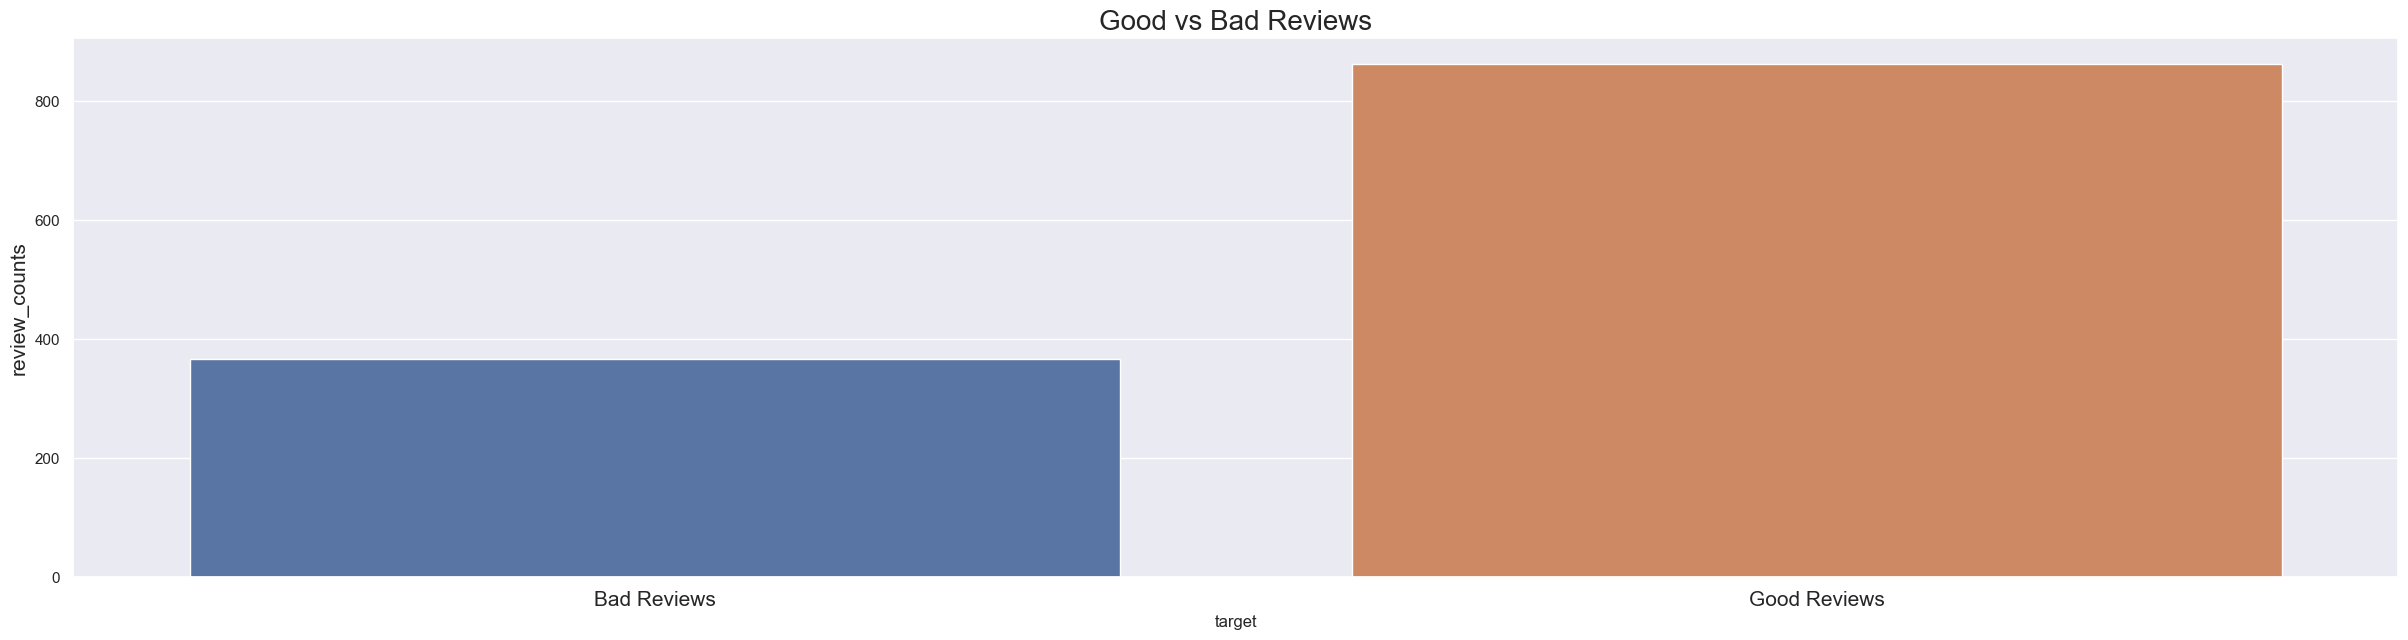

In [321]:
#create a bar chart showing the number of good reviews vs. bad reviews.  
#This can help the team easily visualize where the majority of reviews land
fig = plt.figure(figsize=(30,7))
sns.countplot(data=df,x="target")
plt.xticks([0,1],["Bad Reviews","Good Reviews"],fontsize=15)
plt.ylabel('review_counts',fontsize=15)
plt.title('Good vs Bad Reviews',fontsize=20)

In [322]:
# prep the data to build a positive and negative Top 20 word bar chart
badreviews =df[df.review_stars<=3.0]['review_breakout']
goodreviews = df[df.review_stars>=4.0]['review_breakout']

In [323]:
bad_reviews=pd.DataFrame(pd.Series(chain(*badreviews)).value_counts()).sort_values(by=0,ascending=False).reset_index()
good_reviews=pd.DataFrame(pd.Series(chain(*goodreviews)).value_counts()).sort_values(by=0,ascending=False).reset_index()

In [329]:
d = good_reviews.copy()
d.set_index(['index'],inplace=True)
d = d.iloc[:20]


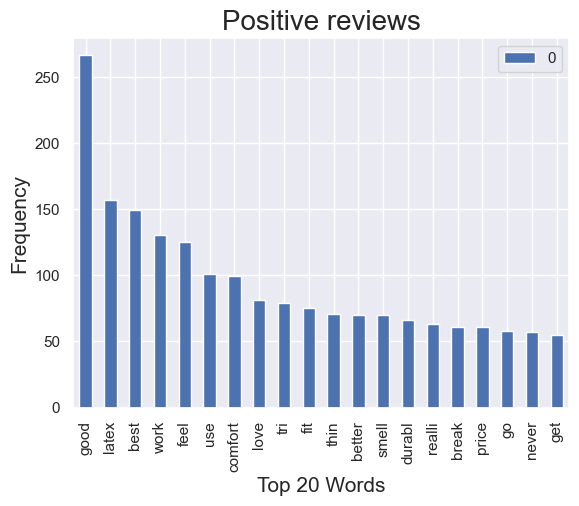

In [330]:
#create Top 20 positive words used bar chart
d.plot.bar()
plt.title('Positive reviews',fontsize=20)
plt.xlabel('Top 20 Words',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.plot(legend=False)
plt.show()


In [331]:
b = bad_reviews.copy()
b.set_index(['index'],inplace=True)
b = b.iloc[:20]

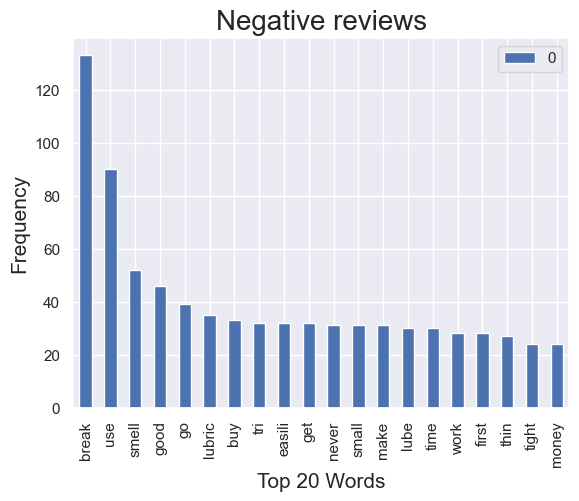

In [332]:
#create Top 20 negative words used bar chart
b.plot.bar()
plt.title('Negative reviews',fontsize=20)
plt.xlabel('Top 20 Words',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.plot(legend=False)
plt.show()